## Business Understanding

### Cenário

A medicina diagnóstica tem um papel
fundamental na jornada de atendimento dos
pacientes de qualquer sistema de saúde em
qualquer lugar do mundo, sendo somente
nos EUA um mercado de aproximadamente
106 bilhões de dólarers com mais de 40 mil
laboratórios, empregando mais de 680 mil
funcionários segundo a ACLA.

Diante disso, uma rede de laboratórios disponibilizou datasets pra realizar uma EDA.

### Qual é a minha meta?

Preciso definir quais são os 3 melhores locais para instalação de novos laboratórios.

### Como posso concluir meu objetivo?

A hipótese inicial é:

O melhor local para se investir, é um local onde existe a maior quantidade de melhores laboratórios(Que prestam mais serviços), os clientes são fidelizados e possui a melhor faixa etária(que mais consome) e a maior de famílias com condições de pagar pelos serviços.

### Perguntas:

* Qual é o Local com maior quantidade de melhores laboratórios(vendem mais)?
* Esses laboratórios possuem alta taxa de conversão?
* Dentre as faixas econômicas,qual a mais consumista?qual destas cidades é a melhor em relação a situação econômica?
* Qual a faixa etária que mais consome?
* Existe alguma correlação entre aquantidade demográfica e o consumo de serviços? 
* As especialidades mais caras são as que mais lucram? Isso define se uma renda alta é fundamental ou não para o negócio

# Data Understanding

### Quais dados eu tenho disponível?

1 - DemographicData: Contém Id de cada região, o ZCTA, a população total,SexRatio, a divisão da população por faixa etária e a média das idades.

2 - EconomicData: Contém o id e ZCTA de cada região e as rendas familiares separadas por quantidade.

3 - df_geocode : Contém o ID do laboratório, o endereço dos mesmos, o zipcode e a latitude e longitude

4 - test_data - contém o código do item, a descrição, categoria ,familia e seu custo

5 - transactional_data - Id de cada paciente, genero, Data de Nascimento, data do serviço, id do serviço, Id do Lab, código do item e custo do teste

# Data Preparation

In [ ]:
# Wrangling
import pandas as pd
import numpy as np



# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
# Leitura do DemographicData_ZCTAs
df_demografica = pd.read_csv('/content/DemographicData_ZCTAs.csv')

# Leitura do EconomicData_ZCTAs
df_economica = pd.read_csv('/content/EconomicData_ZCTAs.csv')

# Leitura do df_geocode
df_geocode = pd.read_csv('/content/df_geocode.csv')

# Leitura do test_data

df_test_data = pd.read_csv("/content/test_data.csv")

# Leitura Transactional Data

df_transactional_data = pd.read_csv("/content/transactional_data.csv", sep = ";",dtype={"Gender": "category"})



## Sanity Checks

In [ ]:
#  leando arquivo encontrado externamente com as informações dos zip codes, ZTCA e cada estado dos EUA

# Site: https://udsmapper.org/zip-code-to-zcta-crosswalk/

zip_ztca = pd.read_excel("/content/ZIPCodetoZCTACrosswalk2021UDS.xlsx")


In [ ]:
# Avaliando data set principal

df_transactional_data.head()


,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Testing Cost
0,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70003237,"9,0"
1,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70000638,"13,0"
2,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70001597,"49,0"
3,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70000103,"11,0"
4,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70000224,"10,0"


#### Valores nulos

In [ ]:
# Identificando Valores Nulos
df_transactional_data.isna().sum()

Patient Id         0
Gender             0
Date of birth      1
Date of service    0
Service Id         0
Lab Id             0
CodItem            0
Testing Cost       0
dtype: int64

In [ ]:
# Remoção do NaN e check
df_transactional_data.dropna(inplace = True)
df_transactional_data.isna().sum()

Patient Id         0
Gender             0
Date of birth      0
Date of service    0
Service Id         0
Lab Id             0
CodItem            0
Testing Cost       0
dtype: int64

#### Duplicatas

In [ ]:
# Identificando Duplicatas
df_transactional_data.duplicated().sum()



14519

In [ ]:
# Eliminando valores duplicados
df_transactional_data.drop_duplicates(inplace = True)

#### Subset - Types Handling

In [ ]:
# Preview
df_transactional_data.dtypes

Patient Id           object
Gender             category
Date of birth        object
Date of service      object
Service Id           object
Lab Id               object
CodItem               int64
Testing Cost         object
dtype: object



##### Datas


In [ ]:
# Transformando object em datetime
df_transactional_data['Date of service'] = pd.to_datetime(df_transactional_data['Date of service'])
df_transactional_data['Date of birth'] = pd.to_datetime(df_transactional_data['Date of birth'])

##### Testing Cost


In [ ]:
# Realocanto ponto no lugar da vírgula de testing Cost

df_transactional_data['Testing Cost'] = df_transactional_data['Testing Cost'].str.replace(',','.', regex=True)


In [ ]:
## Object para int
df_transactional_data['Testing Cost'] = pd.to_numeric(df_transactional_data['Testing Cost'].astype(str))

In [ ]:
# Resutados
df_transactional_data.dtypes

Patient Id                 object
Gender                   category
Date of birth      datetime64[ns]
Date of service    datetime64[ns]
Service Id                 object
Lab Id                     object
CodItem                     int64
Testing Cost              float64
dtype: object

##### Gender

In [ ]:
# Remover "I"
df_transactional_data.Gender.unique()

['F', 'M', 'I']
Categories (3, object): ['F', 'M', 'I']

In [ ]:
# Contagem de valores de cada categoria
df_transactional_data.Gender.value_counts()

F    1491029
M     849683
I          9
Name: Gender, dtype: int64

In [ ]:
# Identificando linhas com I
drop_I_values = df_transactional_data[df_transactional_data["Gender"] == "I"]

# Drop de valores errados

df_transactional_data.drop(axis = 0, index = drop_I_values.index, inplace = True)

# Verificação

df_transactional_data[df_transactional_data["Gender"] == "I"]

,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Testing Cost


#### Outliers

In [ ]:
df_transactional_data.describe()

,CodItem,Testing Cost
count,2.340712e+06,2.340712e+06
mean,7.000322e+07,5.110250e+01
std,1.907708e+03,9.789873e+01
min,7.000004e+07,0.000000e+00
25%,7.000113e+07,1.100000e+01
50%,7.000376e+07,2.400000e+01
75%,7.000446e+07,4.900000e+01
max,7.000900e+07,9.500000e+03


Aqui temos um problema, os valores estão estranhos e é necessário identificar se estão corretos de fato. Existem serviços de custo 0 e outros de custo muito alto. A ideia aqui é comparar com a tabela test_data que contém os valores reais e ver se os valores estão corretos. Caso estejam muito diferentes, utilizar os valores da tabela de custo.

In [ ]:
df_transactional_data[df_transactional_data["Testing Cost"] == 0].value_counts().sum()

40300

In [ ]:
# Unindo as duas tabelas 
test_e_transactional =df_test_data[["CodItem","Testing Cost","Family","Speciality","Category"]].merge(df_transactional_data, on = 'CodItem', how = 'left',indicator = True)
test_e_transactional.head()



,CodItem,Testing Cost_x,Family,Speciality,Category,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,Testing Cost_y,_merge
0,70003237,1.78,CORELAB,BIOCHEMISTRY,CA,10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,9.0,both
1,70003237,1.78,CORELAB,BIOCHEMISTRY,CA,10225666807-BIO002,F,1968-07-16,2019-01-15,573103867832-51,L139,9.0,both
2,70003237,1.78,CORELAB,BIOCHEMISTRY,CA,571700011536-BIO002,F,1961-04-17,2019-01-04,571706608210-36,L131,9.0,both
3,70003237,1.78,CORELAB,BIOCHEMISTRY,CA,574400001820-BIO002,F,1966-01-04,2019-01-17,574400919309-64,L150,9.0,both
4,70003237,1.78,CORELAB,BIOCHEMISTRY,CA,10210855836-BIO003,F,1980-12-25,2019-02-08,575007148185-72,L155,9.0,both


In [ ]:
# Verfificando quais valores estão fora do range que queremos
test_e_transactional[test_e_transactional["_merge"] != "both"]


,CodItem,Testing Cost_x,Family,Speciality,Category,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,Testing Cost_y,_merge


In [ ]:
# Removendo Valores
test_e_transactional.dropna(inplace = True)

In [ ]:
# Como consideramos os valores de Testing_Cost da tabela test_data como a correta, vamos remover a da outra tabela.
test_e_transactional.drop(axis = 1, columns =["Testing Cost_y","_merge"],inplace = True)

In [ ]:
# Verificando a Normalidade dos valores de custo de teste
test_e_transactional["Testing Cost_x"].describe()

count    2.340475e+06
mean     1.559672e+01
std      4.186037e+01
min      0.000000e+00
25%      1.230000e+00
50%      2.390000e+00
75%      4.970000e+00
max      1.762460e+03
Name: Testing Cost_x, dtype: float64

<Axes: xlabel='Testing Cost_x', ylabel='Count'>

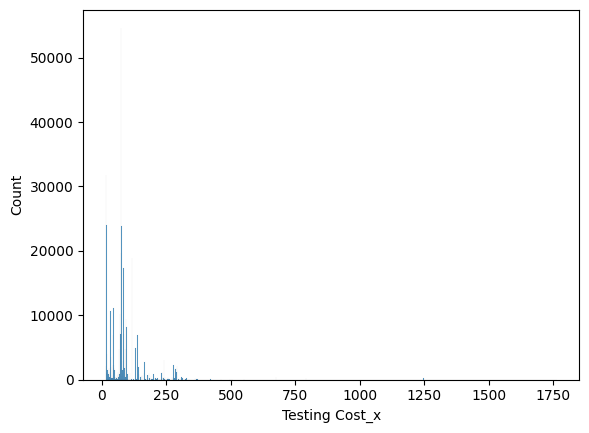

In [ ]:
# Graficamente
sns.histplot(data = test_e_transactional[test_e_transactional["Testing Cost_x"] > 16 ], x ="Testing Cost_x" )

In [ ]:
 # Mais caros
 test_e_transactional[test_e_transactional["Testing Cost_x"] > 900 ]['Speciality'].unique()

array(['SCINTILOGRAPHY', 'BIOMOLECULAR', 'MYCOLOGY', 'SPECIAL GENETICS',
       'INVASIVE PROCEDURE'], dtype=object)

Existem muitos valores baixos e de custo 0. Porém, os procedimentos de custo alto não são um erro, são especialidades realmente caros e de alta rentabilidade.

#### Geolocalizações

Agora que já temos o dataframe com as informações de cada serviço com o preço correto dos mesmos além de informações relevantes como categoria ,especialidade e gênero, já é possível realizar algumas análises sobre esses dados : 

* Qual o Gênero que mais consome serviços?
* Qual o serviço mais consumido?
* Quantos clientes foram fidelizados ?

Antes disso, vou preparar o dataset das localizações de cada serviço e linkar com este dataframe a partir do lab Id. Com esse dataframe final será possível realizar todas as análises e responder todas as perguntas feitas

##### pequenos sanity checks para merge - zip_ztca e df_geocode

In [ ]:
# Retirada de valores NaN
zip_ztca.dropna(inplace = True)
df_geocode.dropna(inplace = True)

In [ ]:
# Transformando variáveis float em int
df_geocode["Zipcode"] = df_geocode["Zipcode"].astype(int)
zip_ztca["ZCTA"] = zip_ztca["ZCTA"].astype(int)

In [ ]:
df_geocode.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 0 to 118
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  118 non-null    int64 
 1   Lab Id      118 non-null    object
 2   Address     118 non-null    object
 3   Location    118 non-null    object
 4   Zipcode     118 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 5.5+ KB


In [ ]:
# Retirando index repetido
df_geocode.drop(axis = 1 , columns = "Unnamed: 0", inplace = True)



In [ ]:
# Renomeando coluna  de  zip_ztca para o merge

zip_ztca.rename(columns = {"ZIP_CODE": "Zipcode"},inplace = True)

In [ ]:
# Realizando o merge apenas das colunas interessantes
zip_ztca_geocode = zip_ztca[["Zipcode","PO_NAME","STATE","ZCTA"]].merge(df_geocode,on = "Zipcode", how = "left" ,indicator = True)

# Retirando valores que não estão presentes nas duas colunas

zip_ztca_geocode[zip_ztca_geocode["_merge"] != 'both'].index

zip_ztca_geocode.drop(axis = 0 , index = zip_ztca_geocode[zip_ztca_geocode["_merge"] != 'both'].index,inplace = True)

In [ ]:
zip_ztca_geocode.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116 entries, 435 to 40381
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Zipcode   116 non-null    int64   
 1   PO_NAME   116 non-null    object  
 2   STATE     116 non-null    object  
 3   ZCTA      116 non-null    int64   
 4   Lab Id    116 non-null    object  
 5   Address   116 non-null    object  
 6   Location  116 non-null    object  
 7   _merge    116 non-null    category
dtypes: category(1), int64(2), object(5)
memory usage: 7.5+ KB


In [ ]:
# Renomeando coluna PO_NAME

zip_ztca_geocode.rename(columns = {"PO_NAME": "City"},inplace = True)

Agora que já temos a tabela com as localizações e a tabela principal, podemos unir as duas com um merge na coluna lab iD

In [ ]:
# merge de zip_ztca_geocode com test_e_transactional

principal_df = test_e_transactional.merge(zip_ztca_geocode[["Lab Id","Zipcode","STATE","ZCTA","City"]], on = "Lab Id", how = "left", indicator = True)

In [ ]:
# Quantos e quais são os laboratórios que não possuem localização

principal_df[principal_df['_merge'] != 'both']["Lab Id"].value_counts()

L158    46662
L523    13894
-2       1589
L665       24
Name: Lab Id, dtype: int64

In [ ]:
# Verificando se os laboratórios faltantes são os unicos valores nulos ( se sim, isso facilita o drop dos valores)
principal_df.isna().sum()

CodItem                0
Testing Cost_x         0
Family                 0
Speciality             0
Category               0
Patient Id             0
Gender                 0
Date of birth          0
Date of service        0
Service Id             0
Lab Id                 0
Zipcode            62169
STATE              62169
ZCTA               62169
City               62169
_merge                 0
dtype: int64

Temos 3 laboratórios que estão sem localização alguma, sem ZTCA ou qualquer tipo de geocode fica impossível  de identificar a loja. Além disso existe um laboratório com nome de "-2 " que provavelmente é um erro.

São quantidades pouco relevantes pois o dataset possui mais de 900 mil linhas. Portanto, tomei a decisão de excluir os dados desses laboratórios.

In [ ]:
# Drop de laboratórios sem localização

principal_df.dropna(inplace = True)

# Verificação
principal_df[principal_df['_merge'] != 'both']["Lab Id"].value_counts()

Series([], Name: Lab Id, dtype: int64)

# Data Exploration

## Questões:


### Qual é o Local com maior quantidade de melhores laboratórios(vendem mais)?

In [ ]:
principal_df.head()

,CodItem,Testing Cost_x,Family,Speciality,Category,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,Zipcode,STATE,ZCTA,City,_merge
0,70003237,1.78,CORELAB,BIOCHEMISTRY,CA,10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,94565.0,CA,94565.0,Pittsburg,both
1,70003237,1.78,CORELAB,BIOCHEMISTRY,CA,10225666807-BIO002,F,1968-07-16,2019-01-15,573103867832-51,L139,95823.0,CA,95823.0,Sacramento,both
2,70003237,1.78,CORELAB,BIOCHEMISTRY,CA,571700011536-BIO002,F,1961-04-17,2019-01-04,571706608210-36,L131,48104.0,MI,48104.0,Ann Arbor,both
3,70003237,1.78,CORELAB,BIOCHEMISTRY,CA,574400001820-BIO002,F,1966-01-04,2019-01-17,574400919309-64,L150,98133.0,WA,98133.0,Seattle,both
4,70003237,1.78,CORELAB,BIOCHEMISTRY,CA,10210855836-BIO003,F,1980-12-25,2019-02-08,575007148185-72,L155,94513.0,CA,94513.0,Brentwood,both


In [ ]:
# Busca pelos laboratórios que aparecem mais vezes. Escolhi os que estão no terceiro quantile pra cima
melhoreslaboratorios= principal_df["Lab Id"].value_counts()

In [ ]:
melhoreslaboratorios = pd.DataFrame(melhoreslaboratorios)
melhoreslaboratorios = melhoreslaboratorios.rename_axis('index').reset_index()
melhoreslaboratorios.rename(columns = {"Lab Id": "Aparicoes","index": "Lab Id"},inplace = True)
melhoreslaboratorios.head()

,Lab Id,Aparicoes
0,L133,121864
1,L152,95208
2,L139,93423
3,L121,88349
4,L166,76158


In [ ]:
# Listando os 10 laboratórios com as maiores aparições
dez_maiores_labs =melhoreslaboratorios[melhoreslaboratorios["Aparicoes"]>649].head(10)
dez_maiores_labs

,Lab Id,Aparicoes
0,L133,121864
1,L152,95208
2,L139,93423
3,L121,88349
4,L166,76158
5,L662,73355
6,L156,69616
7,L123,68470
8,L155,58874
9,L141,50624


In [ ]:
# Encontrando as cidades dos Lab Id

dez_maiores_labs["Lab Id"].values

# Filtrando no dataset principal
cidades_dos_maiores_labs = principal_df[principal_df["Lab Id"].isin(dez_maiores_labs["Lab Id"].values)][["Lab Id","STATE","City"]]

# Agrupando e entendendo o resultado
cidades_dos_maiores_labs = cidades_dos_maiores_labs.groupby(["Lab Id","City","STATE"]).count().reset_index()
cidades_dos_maiores_labs = cidades_dos_maiores_labs.merge(dez_maiores_labs, on ="Lab Id", how = "left").sort_values(by = "Aparicoes", ascending = False)


In [ ]:
# Viz
plt.figure(figsize = (10,8))
px.histogram(cidades_dos_maiores_labs , x = "Lab Id", y ="Aparicoes",labels={"Aparicoes" : "Aparições"}, color="City",pattern_shape="STATE")


<Figure size 1000x800 with 0 Axes>

Agora já temos um norte de quais cidades possuem os laboratórios mais movimentados.

A Cidade com o melhor laboratório é Pittsburg.Porém, em quantidade a cidade da philadelphia vence.

Vou classificar os mais lucrativos, ou seja, visando o faturamento e não apenas as vendas num geral

In [ ]:
labs_mais_lucrativos=principal_df[(principal_df["Lab Id"].isin(dez_maiores_labs["Lab Id"]))&(principal_df["Testing Cost_x"]>0)]
dezlabs_mais_lucrativos = labs_mais_lucrativos.groupby("Lab Id").sum()

In [ ]:
# Viz
plt.figure(figsize = (10,8))
px.bar(dezlabs_mais_lucrativos , y = "Testing Cost_x", x =dezlabs_mais_lucrativos.index,color = "Testing Cost_x",title = 'Labs mais lucrativos',labels={"Testing Cost_x": "Faturamento"},width = 700,color_discrete_sequence= px.colors.sequential.Plasma_r)

<Figure size 1000x800 with 0 Axes>

### Esses laboratórios possuem alta taxa de conversão?

In [ ]:
# Criando variável filtrando os melhores laboratórios
top_vendas_labs  = principal_df[principal_df["Lab Id"].isin(dez_maiores_labs["Lab Id"].values)]
top_vendas_labs

# Contagem total de quantos pacientes cada laboratório teve num total (Para gerar a taxa)

qtd_pacientes_lab = top_vendas_labs[["Lab Id","Patient Id"]].groupby("Lab Id").count().sort_values(by = "Lab Id", ascending =True)

In [ ]:
# Agrupamento por Laboratório e por paciente
conversao = top_vendas_labs.groupby(["Lab Id","Patient Id"]).count()

# Escolhendo apenas os pacientes que executaram mais de um serviço
conversao_final  =conversao[conversao["Service Id"] > 1].reset_index()
pacientes_convertidos = conversao_final[["Lab Id","Patient Id"]].groupby("Lab Id").count().sort_values(by = "Lab Id", ascending =True)

# Calculando Taxa

pacientes_convertidos['taxa_de_conversao'] = (pacientes_convertidos['Patient Id'] / qtd_pacientes_lab['Patient Id']).round(3)

# Printando
pacientes_convertidos = pacientes_convertidos.sort_values(by = "taxa_de_conversao", ascending =True)
pacientes_convertidos

,Patient Id,taxa_de_conversao
Lab Id,,
L121,9465,0.107
L139,10082,0.108
L152,10956,0.115
L123,7997,0.117
L133,14451,0.119
L141,6014,0.119
L662,8935,0.122
L166,9693,0.127
L155,7541,0.128


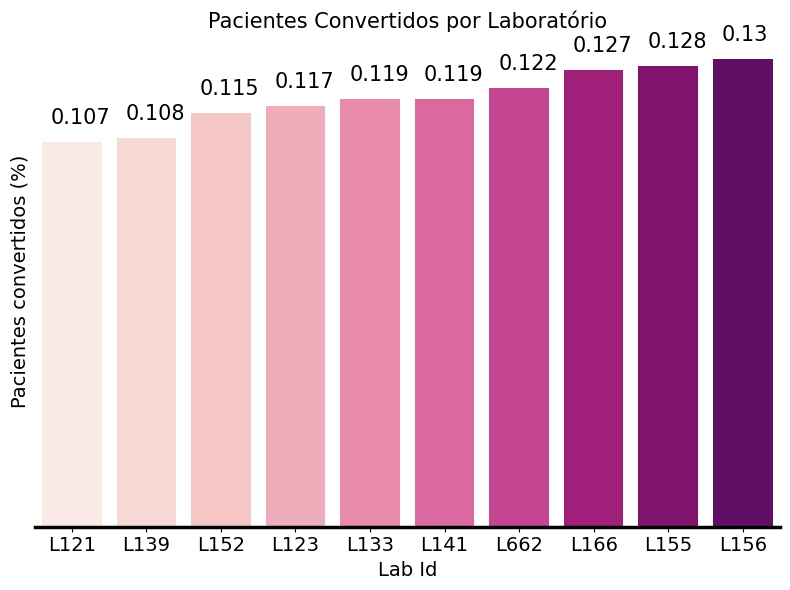

In [ ]:
# Viz

# Definindo altura e comprimento para valores no gráfico
altura = []
for i in pacientes_convertidos['taxa_de_conversao']:
   altura.append(i)
posicao = []
for i in range(0,10,1): 
   posicao.append(i)

fig, ax = plt.subplots(figsize=(8,6))

sns.barplot(x=pacientes_convertidos.index, y=pacientes_convertidos['taxa_de_conversao'], ax=ax, data=pacientes_convertidos,  palette='RdPu')
#adicionando título
ax.set_title("Pacientes Convertidos por Laboratório", fontdict={'fontsize':15})
#mudando e nome e tamanho do label x
ax.set_xlabel('Lab Id', fontdict={'fontsize':14})
#mudando tamanho do label eixo y
ax.set_ylabel('Pacientes convertidos (%)', fontdict={'fontsize':14})
#mudando tamanho dos labels dos ticks
ax.tick_params(labelsize=14)
#aumentando espessura linha inferior
ax.spines['bottom'].set_linewidth(2.5)
#remoção dos outros três eixos
for axis in ['top', 'right', 'left']:
   ax.spines[axis].set_color(None)
#remoção dos ticks
ax.tick_params(axis='y', labelleft=False, left=None)                  
#Colocando a quantidade em cada barra
for i in range(10):
   ax.text(x=posicao[i]-0.28, y=altura[i]+0.005, s=str(altura[i]),   
           fontsize=15)
#otimizar espaço da figure
fig.tight_layout();


Como o  gráfico mostra, as taxas de conversão sao muito parecidas. Os laboratorios com maior taxa de conversão são:

L156  da cidade de Bothell<br/>
L155 de Brentwood <br/>
L166 de Philadelphia

Os dois laboratórios da philadelphia possuem mais de 10% de conversão.

Fazendo uma pequena análise no datafram todo para entender as taxas máximas e mínimas de conversão

In [ ]:
# Conversão de todos os laboratórios

#selecionando os laboratórios acima da media de serviços
conv = principal_df

# Contagem de pacientes por lab
cont = conv[["Lab Id","Patient Id"]].groupby("Lab Id").count().sort_values(by = "Lab Id", ascending =True)

# Agrupamento por Laboratório e por paciente
conv1 = conv.groupby(["Lab Id","Patient Id"]).count()
conv1

# Escolhendo apenas os pacientes que executaram mais de um serviço
conv2  = conv1[conv1["Service Id"] > 1].reset_index()
conv_convertidos = conv2[["Lab Id","Patient Id"]].groupby("Lab Id").count().sort_values(by = "Lab Id", ascending =True)

# taxa
conv_convertidos['taxa_de_conversao'] = (conv_convertidos['Patient Id'] / cont['Patient Id']).round(3)

conv_convertidos.sort_values(by = 'taxa_de_conversao', ascending =False)

,Patient Id,taxa_de_conversao
Lab Id,,
L127,32,0.136
L763,578,0.135
L061,6127,0.133
L080,767,0.131
L070,663,0.131
...,...,...
L666,122,0.095
L131,3370,0.094
L171,1149,0.091


In [ ]:
# Calculando taxa de correlação entre quantidade de clientes e conversão
conv_convertidos.corr()

,Patient Id,taxa_de_conversao
Patient Id,1.000000,0.193178
taxa_de_conversao,0.193178,1.000000


<Axes: xlabel='taxa_de_conversao', ylabel='Patient Id'>

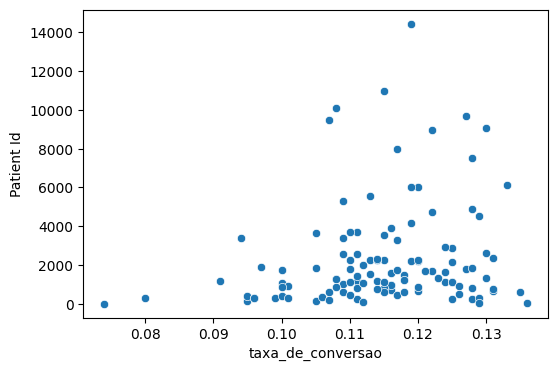

In [ ]:
plt.figure(figsize=(6,4))
sns.scatterplot(conv_convertidos,x=conv_convertidos["taxa_de_conversao"],y=conv_convertidos["Patient Id"])

Uma pequena análise sobre a conversão de clientes é que a maior conversão que os laboratórios conseguem chegar é de 13 %, e mesmo assim a idéia é que quanto mais clientes um laboratório têm, mais esse número diminui. Portanto, os melhores laboratórios se mantêm numa taxa de conversão de 10 à 15%.

Sobre a correlação:<br/>
Apesar de ter um valor baixo, mostra que até certo ponto a quantidade de clientes pode influenciar positivamente na conversão.
A correlação é baixa, porém, têm seu grau de relevância.Então, a melhor opção continua sendo locais com maior quantidade de clientes


### As especialidades mais caras são as que mais lucram? Isso define se uma renda alta é fundamental ou não para o negócio

In [ ]:
# Filtrando pelas Familias de especialidades mais caras
Familias_caras = df_test_data.sort_values(by = "Testing Cost", ascending = False)
Familias_caras = Familias_caras.groupby("Family").sum().sort_values("Testing Cost",ascending = False)

Familias_caras.drop(columns = "CodItem")

,Testing Cost
Family,
GENETICS,58184.83
CORELAB,27721.84
MRI,20614.11
CT SCAN,13041.49
ULTRASOUND,8582.76
INTERNAL,5076.81
X-RAY,4552.96
HEMATO,3451.80
NEONATO,2242.33


In [ ]:
labs_familias=principal_df[principal_df['Family'].isin(Familias_caras.index)& (principal_df['Lab Id'].isin(dez_maiores_labs["Lab Id"]))] 
labs_familias_group =labs_familias.groupby(["Family"]).sum().reset_index()
labs_familias_group = labs_familias_group.sort_values(by ="Testing Cost_x",ascending = False).reset_index()

In [ ]:
labs_familias_group[["Family","Testing Cost_x"]]

,Family,Testing Cost_x
0,ULTRASOUND,4727096.17
1,MRI,2767770.32
2,CT SCAN,2382779.18
3,CARDIO,2203980.33
4,GASTROENT,1996217.81
5,CORELAB,1409970.68
6,VACCINE,1347481.23
7,MAMMO,1237353.70
8,INTERNAL,721874.80
9,X-RAY,641486.95


In [ ]:
# Viz
plt.figure(figsize = (10,8))
px.bar(labs_familias_group , y = "Testing Cost_x", x ="Family",title = 'Familias de Especialidades mais impactantes no faturamento',labels={"Testing Cost_x": "Faturamento Acumulado"},color = "Testing Cost_x",color_discrete_sequence= px.colors.sequential.Plasma_r)

<Figure size 1000x800 with 0 Axes>

Algumas das especialidades mais caras representam praticamente todo o faturamento dos laboratórios. Isso é um indício de que, laboratórios que estão localizados em lugares com famílias mais abastadas tem um potencial de faturamento maior.

### Dentre as faixas econômicas,qual a mais consumista?qual destas cidades é a melhor em relação a situação econômica?

In [ ]:
# print do dataset df_economica
df_economica.head()


,Unnamed: 0,id,Geographic Area Name,TotalHouseholds_LessThan$10.000,TotalHouseholds_$10.000to$14.999,TotalHouseholds_$15.000to$24.999,TotalHouseholds_$25.000to$34.999,TotalHouseholds_$35.000to$49.999,TotalHouseholds_$50.000to$74.999,TotalHouseholds_$75.000to$99.999,TotalHouseholds_$100.000to$149.999,TotalHouseholds_$150.000to$199.999,TotalHouseholds_$200.000OrMore
0,0,8600000US35004,ZCTA5 35004,198,71,298,513,647,1117,529,945,245,61
1,1,8600000US35005,ZCTA5 35005,188,184,318,293,353,562,299,407,67,26
2,2,8600000US35006,ZCTA5 35006,71,20,117,104,154,176,124,194,51,7
3,3,8600000US35007,ZCTA5 35007,396,208,670,462,1173,1854,1578,2224,473,254
4,4,8600000US35010,ZCTA5 35010,700,610,1093,957,1056,1512,807,749,254,249


 Sanity checks

In [ ]:
# Drop index repetido

df_economica.drop(columns = "Unnamed: 0",inplace = True)

In [ ]:
df_economica.dtypes

id                                    object
Geographic Area Name                  object
TotalHouseholds_LessThan$10.000        int64
TotalHouseholds_$10.000to$14.999       int64
TotalHouseholds_$15.000to$24.999       int64
TotalHouseholds_$25.000to$34.999       int64
TotalHouseholds_$35.000to$49.999       int64
TotalHouseholds_$50.000to$74.999       int64
TotalHouseholds_$75.000to$99.999       int64
TotalHouseholds_$100.000to$149.999     int64
TotalHouseholds_$150.000to$199.999     int64
TotalHouseholds_$200.000OrMore         int64
dtype: object

In [ ]:
# Renomeando Geographic Area Name em ZTCA para merge com  dataset
df_economica.rename(columns = {"Geographic Area Name" : "ZCTA"},inplace = True)


In [ ]:
# Removendo 6 letras antes do número do ZTCA para transformar em inteiro

df_economica['ZCTA'] = df_economica['ZCTA'].apply(lambda x: x[5:])
df_economica.head()

,id,ZCTA,TotalHouseholds_LessThan$10.000,TotalHouseholds_$10.000to$14.999,TotalHouseholds_$15.000to$24.999,TotalHouseholds_$25.000to$34.999,TotalHouseholds_$35.000to$49.999,TotalHouseholds_$50.000to$74.999,TotalHouseholds_$75.000to$99.999,TotalHouseholds_$100.000to$149.999,TotalHouseholds_$150.000to$199.999,TotalHouseholds_$200.000OrMore
0,8600000US35004,35004,198,71,298,513,647,1117,529,945,245,61
1,8600000US35005,35005,188,184,318,293,353,562,299,407,67,26
2,8600000US35006,35006,71,20,117,104,154,176,124,194,51,7
3,8600000US35007,35007,396,208,670,462,1173,1854,1578,2224,473,254
4,8600000US35010,35010,700,610,1093,957,1056,1512,807,749,254,249


In [ ]:
df_economica.duplicated().count()


629280

In [ ]:
# Transformar ZTCA em int
df_economica["ZCTA"] = df_economica["ZCTA"].astype(int)

df_economica.head()

,id,ZCTA,TotalHouseholds_LessThan$10.000,TotalHouseholds_$10.000to$14.999,TotalHouseholds_$15.000to$24.999,TotalHouseholds_$25.000to$34.999,TotalHouseholds_$35.000to$49.999,TotalHouseholds_$50.000to$74.999,TotalHouseholds_$75.000to$99.999,TotalHouseholds_$100.000to$149.999,TotalHouseholds_$150.000to$199.999,TotalHouseholds_$200.000OrMore
0,8600000US35004,35004,198,71,298,513,647,1117,529,945,245,61
1,8600000US35005,35005,188,184,318,293,353,562,299,407,67,26
2,8600000US35006,35006,71,20,117,104,154,176,124,194,51,7
3,8600000US35007,35007,396,208,670,462,1173,1854,1578,2224,473,254
4,8600000US35010,35010,700,610,1093,957,1056,1512,807,749,254,249


In [ ]:
valores_repetidos = df_economica[df_economica.duplicated()].index
df_economica.drop(index = valores_repetidos, inplace = True)

In [ ]:
# Variavel com drops de colunas sem relevancia para a analise
zip_ztca_geocode2 = zip_ztca_geocode.drop(columns = ["_merge","Location","Address"])
zip_ztca_geocode2

# Merge
eco_data_cities =zip_ztca_geocode2.merge(df_economica, on ="ZCTA", how = 'left')
eco_data_cities

,Zipcode,City,STATE,ZCTA,Lab Id,id,TotalHouseholds_LessThan$10.000,TotalHouseholds_$10.000to$14.999,TotalHouseholds_$15.000to$24.999,TotalHouseholds_$25.000to$34.999,TotalHouseholds_$35.000to$49.999,TotalHouseholds_$50.000to$74.999,TotalHouseholds_$75.000to$99.999,TotalHouseholds_$100.000to$149.999,TotalHouseholds_$150.000to$199.999,TotalHouseholds_$200.000OrMore
0,1605,Worcester,MA,1605,L069,8600000US01605,1325,958,1576,835,1550,1654,1074,1080,304,317
1,1606,Worcester,MA,1606,L517,8600000US01606,366,305,799,641,1078,1367,1086,1478,605,434
2,1701,Framingham,MA,1701,L173,8600000US01701,439,370,363,733,949,1693,1396,2870,1738,2503
3,1702,Framingham,MA,1702,L522,8600000US01702,992,648,1027,1217,1871,2761,2231,2275,1197,993
4,1840,Lawrence,MA,1840,L160,8600000US01840,434,268,479,215,250,246,154,120,36,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,98133,Seattle,WA,98133,L150,8600000US98133,1124,1262,1759,1696,2266,3361,3198,3709,1532,1743
112,98148,Seattle,WA,98148,L442,8600000US98148,266,86,411,411,659,937,487,811,338,210
113,98148,Seattle,WA,98148,L165,8600000US98148,266,86,411,411,659,937,487,811,338,210
114,98370,Poulsbo,WA,98370,L539,8600000US98370,449,249,748,604,1124,2132,1898,2726,1171,1292


In [ ]:
# Filtrando os dados economicos das cidades dos laboratórios
best_cities = ['Philadelphia', 'Duluth', 'Douglasville', 'Brentwood', 'Pittsburg','Sacramento', 'Bellevue', 'Bothell', 'Kirkland']
eco_data_10cities = eco_data_cities[(eco_data_cities["Lab Id"].isin(dez_maiores_labs["Lab Id"].values))]
eco_data_10cities

# drop de duplicatas para ter apenas valores unicos de cada cidade

final_eco_data = eco_data_10cities.drop(columns = ["id","Zipcode"])
final_eco_data

,City,STATE,ZCTA,Lab Id,TotalHouseholds_LessThan$10.000,TotalHouseholds_$10.000to$14.999,TotalHouseholds_$15.000to$24.999,TotalHouseholds_$25.000to$34.999,TotalHouseholds_$35.000to$49.999,TotalHouseholds_$50.000to$74.999,TotalHouseholds_$75.000to$99.999,TotalHouseholds_$100.000to$149.999,TotalHouseholds_$150.000to$199.999,TotalHouseholds_$200.000OrMore
37,Philadelphia,PA,19120,L166,3555,1664,2840,3114,3656,3494,2374,1992,594,162
40,Philadelphia,PA,19143,L123,3665,2426,3441,3131,3500,3824,2405,1647,529,534
53,Duluth,GA,30096,L152,1277,1020,2214,2771,3809,5563,3485,3025,1233,1428
54,Douglasville,GA,30135,L662,905,623,1566,1416,2149,4336,3762,4690,1910,1055
79,Brentwood,CA,94513,L155,551,374,1018,954,1784,2170,2471,4602,3137,3629
87,Pittsburg,CA,94565,L133,1248,1298,1707,2074,3224,5188,4567,4846,2219,1997
95,Sacramento,CA,95823,L139,1879,1363,2576,3099,3493,4716,2575,2870,587,552
98,Bellevue,WA,98008,L121,312,159,262,387,741,1115,1020,1592,1224,2466
99,Bothell,WA,98012,L156,416,406,722,933,1740,3156,3517,5644,4145,3567
102,Kirkland,WA,98034,L141,672,305,629,760,1474,2226,2609,3797,2317,2857


In [ ]:
# Diminuindo a quantidade de features agrupando as características

#Classe baixa
final_eco_data["classe_baixa"] = final_eco_data["TotalHouseholds_LessThan$10.000"] + final_eco_data["TotalHouseholds_$10.000to$14.999"]+final_eco_data["TotalHouseholds_$15.000to$24.999"]

#Classe média 

final_eco_data["classe_media"] = final_eco_data["TotalHouseholds_$25.000to$34.999"] + final_eco_data["TotalHouseholds_$35.000to$49.999"]+final_eco_data["TotalHouseholds_$50.000to$74.999"]+final_eco_data["TotalHouseholds_$75.000to$99.999"]

# Classe alta
final_eco_data["classe_alta"] = final_eco_data["TotalHouseholds_$100.000to$149.999"] + final_eco_data["TotalHouseholds_$150.000to$199.999"]+final_eco_data["TotalHouseholds_$200.000OrMore"]




In [ ]:
# Remove de colunas
final_eco_data.drop(final_eco_data.columns[4:14],axis =1,inplace = True)

In [ ]:
final_eco_data

,City,STATE,ZCTA,Lab Id,classe_baixa,classe_media,classe_alta
37,Philadelphia,PA,19120,L166,8059,12638,2748
40,Philadelphia,PA,19143,L123,9532,12860,2710
53,Duluth,GA,30096,L152,4511,15628,5686
54,Douglasville,GA,30135,L662,3094,11663,7655
79,Brentwood,CA,94513,L155,1943,7379,11368
87,Pittsburg,CA,94565,L133,4253,15053,9062
95,Sacramento,CA,95823,L139,5818,13883,4009
98,Bellevue,WA,98008,L121,733,3263,5282
99,Bothell,WA,98012,L156,1544,9346,13356
102,Kirkland,WA,98034,L141,1606,7069,8971


In [ ]:
plt.figure(figsize = (10,8))
px.histogram(final_eco_data , x = "Lab Id", y =["classe_baixa","classe_media","classe_alta"],color_discrete_sequence=["darkturquoise","slateblue","purple"],barmode = 'group', title = 'Classe econômica da população em cada cidade',height=700,text_auto='.2s')


<Figure size 1000x800 with 0 Axes>

Conforme avaliamos anteriormente, o ideal é que o local seja abastado de famílias com uma renda maior( entre classe média e classe alta)

* L133 possui a melhor proporção e quantidade de classe média e alta
* L156 possui a maior parcela de famílias ricas
* L166 e L123 possuem a maior quantidade de familias menos abastadas e as menores quantidades de familias ricas

### Existe alguma correlação entre a quantidade demográfica e o consumo de serviços?

In [ ]:
df_demografica.head()

,Unnamed: 0,Id,GeographicAreaName,TotalPopulation,SexRatio(males per 100 females),Population_Under5Years,Population_5to9Years,Population_10to14Years,Population_15to19Years,Population_20to24Years,Population_25to34Years,Population_35to44Years,Population_45to54Years,Population_55to59Years,Population_60to64Years,Population_65to74Years,Population_75to84Years,Population_85YearsAndOver,MedianAgeInYears
0,0,8600000US35004,ZCTA5 35004,12045,94.1,805,1075,898,477,578,2088,1628,1200,886,683,1017,534,176,35.5
1,1,8600000US35005,ZCTA5 35005,7344,86.1,504,453,511,499,214,788,795,968,612,561,798,485,156,44.0
2,2,8600000US35006,ZCTA5 35006,2883,108.2,96,153,303,129,156,183,367,430,296,260,280,201,29,47.2
3,3,8600000US35007,ZCTA5 35007,26332,95.0,1936,1992,1837,1762,1376,3119,3849,3907,1665,1323,2096,1106,364,37.7
4,4,8600000US35010,ZCTA5 35010,20613,90.5,1306,1465,944,1217,1128,2513,2106,2950,1512,1472,2421,1155,424,42.6


In [ ]:
df_demografica.drop(axis = 1,columns = "Unnamed: 0",inplace= True)

In [ ]:
df_demografica.rename(columns={"GeographicAreaName":"ZCTA"},inplace = True)
# Removendo 6 letras antes do número do ZTCA para transformar em inteiro

df_demografica['ZCTA'] = df_demografica['ZCTA'].apply(lambda x: x[6:])
df_demografica.head()

,Id,ZCTA,TotalPopulation,SexRatio(males per 100 females),Population_Under5Years,Population_5to9Years,Population_10to14Years,Population_15to19Years,Population_20to24Years,Population_25to34Years,Population_35to44Years,Population_45to54Years,Population_55to59Years,Population_60to64Years,Population_65to74Years,Population_75to84Years,Population_85YearsAndOver,MedianAgeInYears
0,8600000US35004,35004,12045,94.1,805,1075,898,477,578,2088,1628,1200,886,683,1017,534,176,35.5
1,8600000US35005,35005,7344,86.1,504,453,511,499,214,788,795,968,612,561,798,485,156,44.0
2,8600000US35006,35006,2883,108.2,96,153,303,129,156,183,367,430,296,260,280,201,29,47.2
3,8600000US35007,35007,26332,95.0,1936,1992,1837,1762,1376,3119,3849,3907,1665,1323,2096,1106,364,37.7
4,8600000US35010,35010,20613,90.5,1306,1465,944,1217,1128,2513,2106,2950,1512,1472,2421,1155,424,42.6


In [ ]:
# Str para int
df_demografica['ZCTA'] = df_demografica['ZCTA'].astype(int)

# Sex ratio rename

df_demografica.rename(columns={"SexRatio(males per 100 females)":"sex_ratio"},inplace = True)

In [ ]:
# Sex ratio em %

df_demografica["sex_ratio"] = df_demografica["sex_ratio"]/100

In [ ]:
df_demografica.head()

# Criança - até 14 anos

#Classe baixa
df_demografica["criancas"] = df_demografica["Population_Under5Years"]+df_demografica["Population_5to9Years"]+df_demografica["Population_10to14Years"]

#Jovem - 15 a 24 anos

df_demografica["jovens"] = df_demografica["Population_15to19Years"]+df_demografica["Population_20to24Years"]
# Adulto - 25 até 59

df_demografica["Jovem-Adultos"] = df_demografica["Population_25to34Years"]+df_demografica["Population_35to44Years"]

# Adulto maioridade - 45 até 59

df_demografica["Adulto-maior"] = df_demografica["Population_45to54Years"]+df_demografica["Population_55to59Years"]

# Idoso - 60 para frente

df_demografica["Idosos"] = df_demografica["Population_60to64Years"]+df_demografica["Population_65to74Years"]+df_demografica["Population_75to84Years"]+df_demografica["Population_85YearsAndOver"]


df_demografica.drop(df_demografica.columns[4:17],axis =1,inplace = True)


In [ ]:
# Verificando duplicatas
df_demografica["ZCTA"].duplicated().any()


False

In [ ]:
# Merge
demografia =  df_demografica.merge(eco_data_cities[["Zipcode","City","STATE","ZCTA","Lab Id"]],on= "ZCTA",how ='left')

In [ ]:
# Retirando valores NaN
demografia.dropna()

,Id,ZCTA,TotalPopulation,sex_ratio,MedianAgeInYears,criancas,jovens,Jovem-Adultos,Adulto-maior,Idosos,Zipcode,City,STATE,Lab Id
2883,8600000US94506,94506,25240,0.870,45.0,5434,3116,4081,7100,5509,94506.0,Danville,CA,L124
2890,8600000US94513,94513,64313,0.945,40.5,13031,9157,14178,14247,13700,94513.0,Brentwood,CA,L155
2897,8600000US94520,94520,38753,1.082,34.8,7457,4817,13235,7143,6101,94520.0,Concord,CA,L541
2898,8600000US94520,94520,38753,1.082,34.8,7457,4817,13235,7143,6101,94520.0,Concord,CA,L149
2899,8600000US94520,94520,38753,1.082,34.8,7457,4817,13235,7143,6101,94520.0,Concord,CA,L967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30819,8600000US98133,98133,48650,0.923,39.9,6430,4908,15990,9757,11565,98133.0,Seattle,WA,L150
30824,8600000US98148,98148,12149,0.953,35.8,2578,1271,3690,2329,2281,98148.0,Seattle,WA,L442
30825,8600000US98148,98148,12149,0.953,35.8,2578,1271,3690,2329,2281,98148.0,Seattle,WA,L165
30955,8600000US98370,98370,31278,0.940,43.4,5394,3428,7366,6404,8686,98370.0,Poulsbo,WA,L539


In [ ]:
# Filtrando pelos 10 laboratórios escolhidos e suas respectivas cidades
dados_demograficos = demografia[demografia["Lab Id"].isin(dez_maiores_labs["Lab Id"].values)].sort_values(by="TotalPopulation",ascending =True)
dados_demograficos

,Id,ZCTA,TotalPopulation,sex_ratio,MedianAgeInYears,criancas,jovens,Jovem-Adultos,Adulto-maior,Idosos,Zipcode,City,STATE,Lab Id
30749,8600000US98008,98008,25719,1.022,42.3,4639,2450,6820,5888,5922,98008.0,Bellevue,WA,L121
30768,8600000US98034,98034,43471,0.988,36.8,7724,4238,15059,7937,8513,98034.0,Kirkland,WA,L141
2890,8600000US94513,94513,64313,0.945,40.5,13031,9157,14178,14247,13700,94513.0,Brentwood,CA,L155
25736,8600000US19143,19143,64630,0.805,32.9,13458,8272,20225,10207,12468,19143.0,Philadelphia,PA,L123
30752,8600000US98012,98012,67427,1.002,35.4,15011,7357,21921,12995,10143,98012.0,Bothell,WA,L156
5638,8600000US30135,30135,67710,0.925,37.7,14439,9011,17034,14584,12642,30135.0,Douglasville,GA,L662
5612,8600000US30096,30096,68691,0.890,35.8,13460,9004,20817,14634,10776,30096.0,Duluth,GA,L152
25713,8600000US19120,19120,74060,0.906,30.2,18164,12252,19377,14898,9369,19120.0,Philadelphia,PA,L166
3440,8600000US95823,95823,79440,0.945,31.4,19699,10982,22976,13294,12489,95823.0,Sacramento,CA,L139
2933,8600000US94565,94565,97671,1.005,34.1,21184,13938,29328,18428,14793,94565.0,Pittsburg,CA,L133


In [ ]:
plt.figure(figsize = (10,8))
px.bar(dados_demograficos , y = "Lab Id", x =["TotalPopulation"],color='City',title = 'Quantidade de habitantes por cidade',height=700,color_discrete_sequence= px.colors.sequential.Plasma_r,orientation ='h',text="City")



<Figure size 1000x800 with 0 Axes>

In [ ]:
# Viz

plt.figure(figsize = (10,8))
px.histogram(dados_demograficos , x = "Lab Id", y =["criancas","jovens","Jovem-Adultos","Adulto-maior","Idosos"],color_discrete_sequence= px.colors.sequential.Turbo,barmode = 'group', title = 'Faixa etátia dos consumidores',height=700,text_auto='.2s')

<Figure size 1000x800 with 0 Axes>

In [ ]:
# Identificando a idade de cada id
from datetime import date
import datetime as dt

In [ ]:
principal_df["year_birth"]=principal_df["Date of birth"].dt.year 
principal_df["year_birth"].astype(int)

0          1976
1          1968
2          1961
3          1966
4          1980
           ... 
2340470    1989
2340471    1984
2340472    1976
2340473    1983
2340474    1983
Name: year_birth, Length: 2278306, dtype: int64

In [ ]:
hoje = date.today()
ano_atual = hoje.year
ano_atual
principal_df["age"] = ano_atual - principal_df["year_birth"]

In [ ]:
idade_media_clientes_por_regiao =principal_df.groupby("Patient Id").mean()
idade_media_clientes_por_regiao["age"].mean()

42.880095350310974

### Os generos consomem em qual proporção?

In [ ]:
# Separando apenas valores
sexratio_consumo = principal_df["Gender"].value_counts()

In [ ]:
# Transformando em dataset
sexratio_consumo =pd.DataFrame(sexratio_consumo).reset_index()

In [ ]:
# Criando coluna de porcentagem
sexratio_consumo["percent"] = sexratio_consumo["Gender"]/sexratio_consumo["Gender"].sum()

In [ ]:
# Retirando index com valor nulo
sexratio_consumo.drop(axis= 0,index =2,inplace = True )

Text(0.5, 1.0, 'Maior Gênero Consumista')

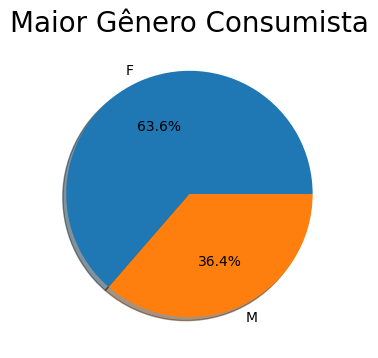

In [ ]:
# Viz
fg,ax = plt.subplots(figsize = (6,4))
plt.pie(sexratio_consumo["percent"],labels =sexratio_consumo["index"],autopct = "%.1f%%",shadow = True);
ax.set_title('Maior Gênero Consumista',fontsize = 20)

In [ ]:
# Quais os zipcodes com as melhores proporções sexratio
dados_demograficos.sort_values(by="sex_ratio",ascending=True).head(3)

,Id,ZCTA,TotalPopulation,sex_ratio,MedianAgeInYears,criancas,jovens,Jovem-Adultos,Adulto-maior,Idosos,Zipcode,City,STATE,Lab Id
25736,8600000US19143,19143,64630,0.805,32.9,13458,8272,20225,10207,12468,19143.0,Philadelphia,PA,L123
5612,8600000US30096,30096,68691,0.890,35.8,13460,9004,20817,14634,10776,30096.0,Duluth,GA,L152
25713,8600000US19120,19120,74060,0.906,30.2,18164,12252,19377,14898,9369,19120.0,Philadelphia,PA,L166


# Resultados

## Respostas das perguntas:

 * 1 Qual é o Local com maior quantidade de melhores laboratórios(vendem mais)?
<br/>
Laboratórios:<br/>
1 L 133<br/>
2 L 152<br/>
3 L 139
<br/>

*  2 Esses laboratórios possuem alta taxa de conversão?<br/>

As maiores taxas de conversão variam entre 9 e 14 %, sendo as maiores dos laboratórios:<br/>
1 L 156	<br/>
2 L 155<br/>
3 L 166<br/>
<br/>

* 3 As especialidades mais caras são as que mais lucram? Isso define se uma renda alta é fundamental ou não para o negócio?<br/>

Sim, a maior parte do faturamento provém de especialidades mais caras,indicando que é melhor estar numa região mais abastada<br/>
<br/>

* 4 qual destas cidades é a melhor em relação a situação econômica?<br/>

Laboratórios L 133,L155 e L156 são os que residem em localizações mais ricas.<br/>
<br/>

* 5 Existe alguma correlação entre aquantidade demográfica e o consumo de serviços?<br/>

A média etária dos clientes é de 41 anos. Logo a cidade ideal deve possuir uma grande quantidade de pessoas nesta  faixa de idade, ou próximas desta. Logo:

1 -L 133<br/>
2-L 152<br/>
3- L 166<br/>
4 -L 139 possui uma alta quantidade de adultos potenciais clientes<br/>
<br/>

* 6 Os generos consomem em qual proporção?<br/>

O genero feminino representa a maior parte dos clientes com um total de 63%. Logo, cidades com uma sex ratio menor é mais vantajoso.

os melhores zipcodes desta qualificação são os laboratórios:<br/>

1-L123<br/>
2-L152<br/>
3-L166<br/>


## Conclusão :

In [ ]:
# Melhores Zipcodes

zipcodes = principal_df[principal_df["Lab Id"].isin(["L133","L152","L139"])].drop_duplicates("Lab Id")["Zipcode"].to_list()
zipcodes

[94565.0, 95823.0, 30096.0]

L 133
Este laboratório se localiza em Pittsburg,  possui um dos maiores faturamentos e números de serviços realizados. É o Zipcode com a maior população dentre os analisados e possui uma taxa de conversão de clientes boa em torno de 11%. Possui uma ótima proporção de classe econômica e o maior número da faixa etária mais consumista.

L 152
Está entre o top 3 de vendas e número de serviços. Duluth é o terceiro maior Zipcode, possui ótima distribições de faixa etária e é abastada de famílias classe média. É o segundo local com maior proporção de mulheres. 

L 139
Laboratório mais lucrativo e o terceiro maior em vendas. Conversão de 10% de clientes. Se localiza em Sacramento, que é a segunda maior cidade em número de pessoas, é repleta de pessoas que precedem a faixa etária ideal, ou seja, futuramente vai ter muitos lucros. 